In [1]:
#Importando as bibliotecas
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
import re
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

In [2]:
#Deletando as linhas com valores em branco
data_set='DISNEY.csv'
df=pd.read_csv(data_set,encoding="cp1252",na_values=['missing'], delimiter=';')
df=df.dropna().reset_index()
print ("Valores em branco :  ", df.isnull().sum().values.sum())
df.head()

Valores em branco :   0


,index,Review_ID,Rating,Review_Text,Branch
0,0,670772142,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,1,670682799,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,2,670623270,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,3,670607911,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,670607296,4,the location is not in the city took around 1 ...,Disneyland_HongKong


In [3]:
#Deletando as linhas duplicadas
df.drop_duplicates(subset='Review_Text', inplace=True, keep='first')

In [4]:
#Entendendo as colunas do DF
df.describe()

,index,Review_ID,Rating
count,41128.000000,4.112800e+04,41128.000000
mean,20569.001337,3.198747e+08,4.225102
std,11876.150843,1.655141e+08,1.060065
min,0.000000,1.398724e+06,1.000000
25%,10285.750000,1.754196e+08,4.000000
50%,20568.500000,2.924631e+08,5.000000
75%,30854.250000,4.497034e+08,5.000000
max,41137.000000,6.708014e+08,5.000000


In [5]:
df.count()

index          41128
Review_ID      41128
Rating         41128
Review_Text    41128
Branch         41128
dtype: int64

In [6]:
#Descobrindo qual é a representativadede da minha base entre as variáveis
print(df['Branch'].value_counts())
print(df['Rating'].value_counts())

Branch
Disneyland_California    18744
Disneyland_Paris         13066
Disneyland_HongKong       9318
Name: count, dtype: int64
Rating
5    22473
4    10322
3     4875
2     2034
1     1424
Name: count, dtype: int64


In [7]:
#Vamos agora montar a análise de sentimentos
df2 = df.copy()
df2['review length']=df2['Review_Text'].apply(lambda x:len(x))

#==
features = df2['Review_Text'].values
#=== 
processed_features = []

for sentence in range(0, len(features)):
    # Removendo todos os caracteres de site
    processed_feature = re.sub('(https?://\S+)', '', str(features[sentence]))
    
    # Removendo caracteres especiais
    processed_feature = re.sub(r'\W', ' ', processed_feature)

    # Removendo todos os caracteres únicos
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Removendo todos os caracteres do início
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituindo espaços multiplos
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removendo outros caracteres especiais
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Convertendo o texto para caixa baixa
    processed_feature = processed_feature.lower()

    # Removendo todos os termos comuns não relevantes
    palavras_irrelevantes = '|'.join({'disneyland', 'disney', 'land', 'ride', 'park', 'day'})
    processed_feature = re.sub(palavras_irrelevantes, '', processed_feature)

    processed_features.append(processed_feature)
#=== 
df3=pd.DataFrame()
df3['reviews']=processed_features
#=======
from textblob import TextBlob
# Criando função para chegar na subjetividade
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Criando a função para conseguir a polaridade
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Criando duas novas colunas para conseguirmos a polaridade e subjetividade
df3['Subjectivity'] = df3['reviews'].apply(getSubjectivity)
df3['Polarity'] = df3['reviews'].apply(getPolarity)

#Atribuindo scores para os sentimentos
def getAnalysis(score):
 if score < 0:
  return 'Negative'
 elif score > 0:
  return 'Positive'
 else:
  return 'Neutral'
df3['Analysis'] = df3['Polarity'].apply(getAnalysis)
df3

,reviews,Subjectivity,Polarity,Analysis
0,if you ve ever been to anywhere you ll find ...,0.561481,0.239352,Positive
1,its been while since last time we visit hk ye...,0.459783,0.205797,Positive
2,thanks god it wasn too hot or too humid when w...,0.434857,0.119238,Positive
3,hk is great compact unfortunately there is q...,0.512143,0.189286,Positive
4,the location is not in the city took around 1 ...,0.437500,0.266667,Positive
...,...,...,...,...
41123,i went to paris in july 03 and thought it was...,0.570682,0.225000,Positive
41124,2 adults and 1 child of 11 visited paris begi...,0.637045,0.194773,Positive
41125,my eleven year old daughter and myself went to...,0.479670,0.231319,Positive
41126,this hotel part of the paris complex is wonde...,0.559821,0.255952,Positive


In [8]:
#Juntando o resultado com o DataFrame original
resultado = df.copy()
resultado['Sentiment'] = df3['Analysis']
resultado['Nota'] = resultado['Rating'].apply(lambda x:'Negative' if x<3 else 'Positive' if x>3 else 'Neutral')

resultado['Reviews_Text']=df3['reviews']
resultado.drop(['Review_Text', 'Review_ID'],axis=1,inplace=True)

In [9]:
df_copy=resultado.copy()
resultado.head()

,index,Rating,Branch,Sentiment,Nota,Reviews_Text
0,0,4,Disneyland_HongKong,Positive,Positive,if you ve ever been to anywhere you ll find ...
1,1,4,Disneyland_HongKong,Positive,Positive,its been while since last time we visit hk ye...
2,2,4,Disneyland_HongKong,Positive,Positive,thanks god it wasn too hot or too humid when w...
3,3,4,Disneyland_HongKong,Positive,Positive,hk is great compact unfortunately there is q...
4,4,4,Disneyland_HongKong,Positive,Positive,the location is not in the city took around 1 ...


Accuracy Score:  0.5263190367538376
              precision    recall  f1-score   support

           0       0.13      0.14      0.13      3458
           1       0.92      0.92      0.92     37670

    accuracy                           0.85     41128
   macro avg       0.53      0.53      0.53     41128
weighted avg       0.85      0.85      0.85     41128



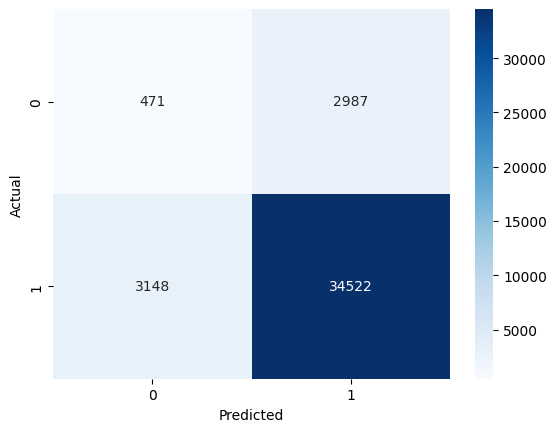

In [10]:
# Avaliando o desempenho do modelo
teste = resultado.copy()
teste['Nota'] = teste['Nota'].apply(lambda x: 0 if x=='Negative' else 1)
teste['Sentiment'] = teste['Sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
print('Accuracy Score: ', balanced_accuracy_score(teste['Nota'], teste['Sentiment']))
print(classification_report(teste['Nota'], teste['Sentiment']))

cm = confusion_matrix(teste['Nota'], teste['Sentiment'])
cm = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
print('Confusion Matrix: ', confusion_matrix(teste['Nota'], teste['Sentiment']))

Confusion Matrix:  [[  471  2987]
 [ 3148 34522]]


In [20]:
# modelo de análise de sentimento com textblob usa a biblioteca pattern para análise de sentimento. Embora o modelo seja validado para avaliações de livros, ele não é tão preciso para outros contextos.
from textblob import TextBlob
print(TextBlob("I don't feel very well").sentiment)
print(TextBlob("I feel stoked about this!").sentiment)

Sentiment(polarity=0.2, subjectivity=0.3)
Sentiment(polarity=0.0, subjectivity=0.0)


Text(0.5, 1.0, 'Previsto')

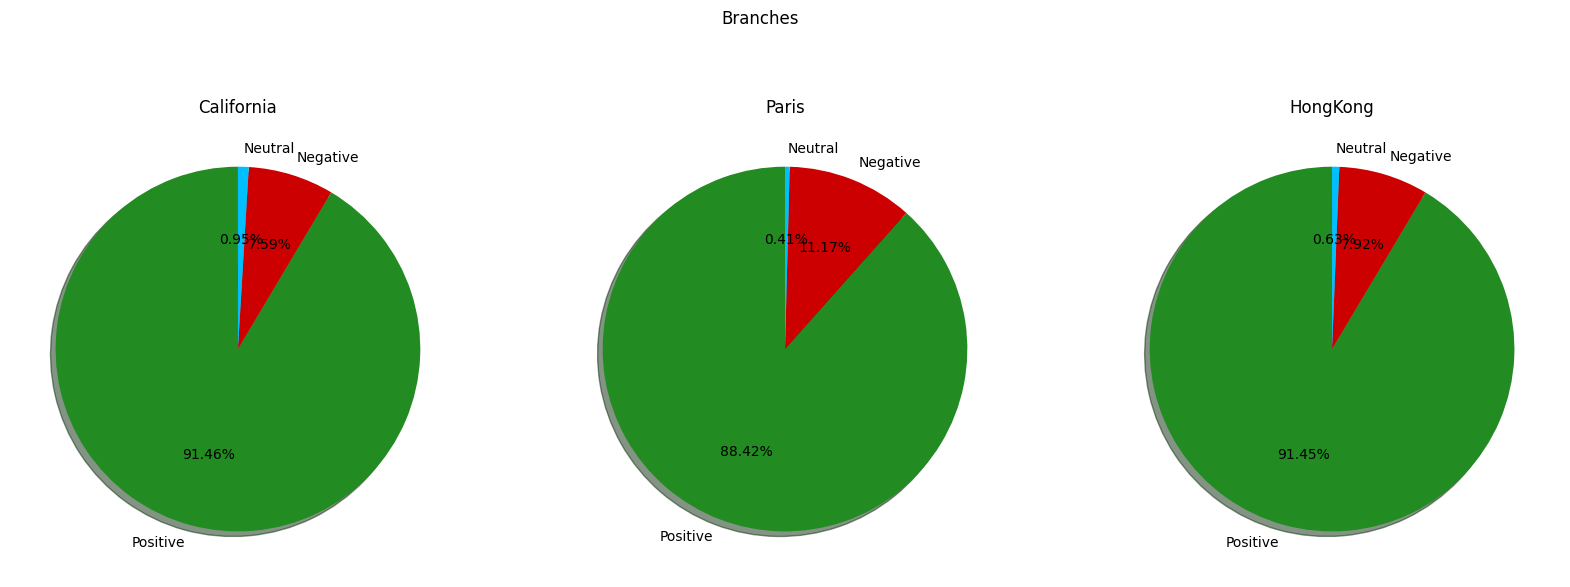

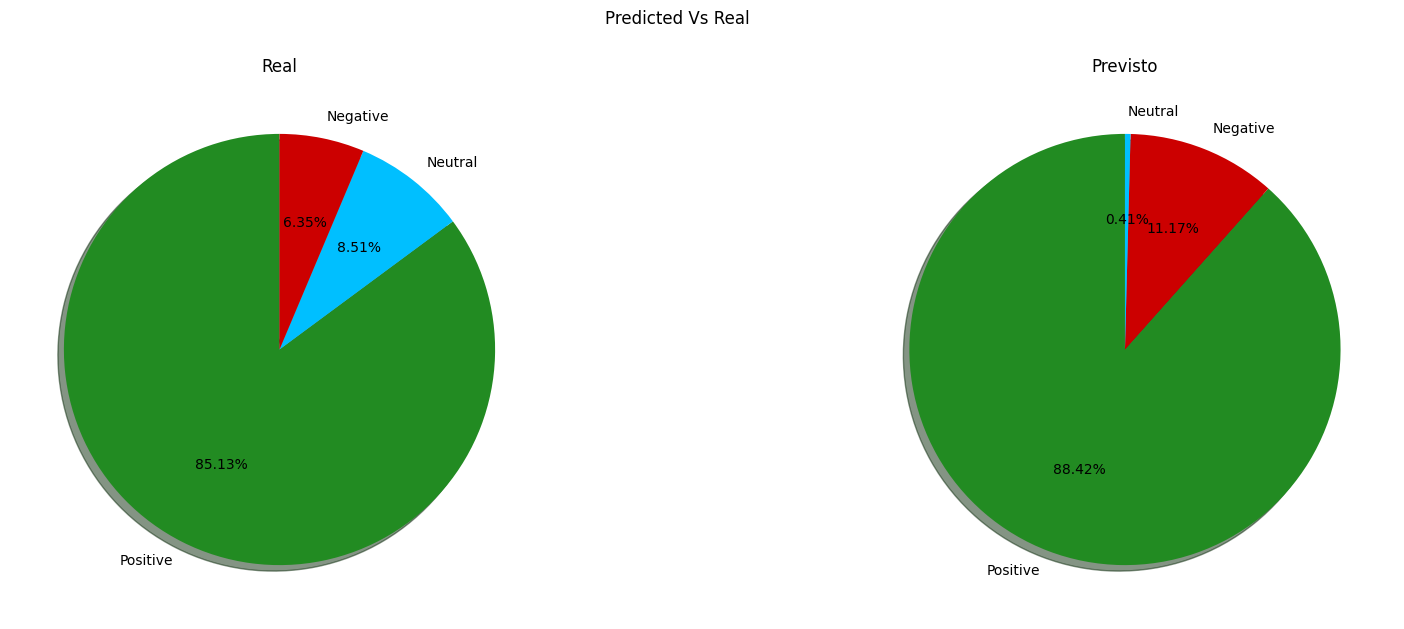

In [17]:
#Fazendo um gráficos de pizza para entender a proporção dos resultados entre as variáveis

california=resultado.loc[resultado['Branch']=='Disneyland_California']
paris=resultado.loc[resultado['Branch']=='Disneyland_Paris']
hong_kong=resultado.loc[resultado['Branch']=='Disneyland_HongKong']


label_cal=california['Sentiment'].value_counts(sort = True).index
size_cal=california['Sentiment'].value_counts(sort = True)

label_par=paris['Sentiment'].value_counts(sort = True).index
size_par=paris['Sentiment'].value_counts(sort = True)

label_hon=hong_kong['Sentiment'].value_counts(sort = True).index
size_hon=hong_kong['Sentiment'].value_counts(sort = True)


real=resultado.loc[resultado['Branch']=='Disneyland_California']
previsto=resultado.loc[resultado['Branch']=='Disneyland_Paris']


label_real=real['Nota'].value_counts(sort = False).index
size_real=real['Nota'].value_counts(sort = False)

label_prev=previsto['Sentiment'].value_counts(sort = False).index
size_prev=previsto['Sentiment'].value_counts(sort = False)


fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=False)
fig.suptitle('Branches')
axes[0].pie(size_cal,labels=label_cal,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#228B22','#CC0000','#00BFFF'])
axes[0].set_title('California')
axes[1].pie(size_par,labels=label_par,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#228B22','#CC0000','#00BFFF'])
axes[1].set_title('Paris')
axes[2].pie(size_hon,labels=label_hon,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#228B22','#CC0000','#00BFFF'])
axes[2].set_title('HongKong')

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=False)
fig.suptitle('Predicted Vs Real')
axes[0].pie(size_real,labels=label_real,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#228B22','#00BFFF','#CC0000'])
axes[0].set_title('Real')
axes[1].pie(size_prev,labels=label_prev,startangle=90,shadow=1,autopct='%1.2f%%',colors=['#228B22','#CC0000','#00BFFF'])
axes[1].set_title('Previsto')

<h1>Nuvem de palavras</h1>

In [13]:
resultado['Reviews_Text']=resultado['Reviews_Text'].astype('str')
review_text = " ".join(i for i in resultado['Reviews_Text'])


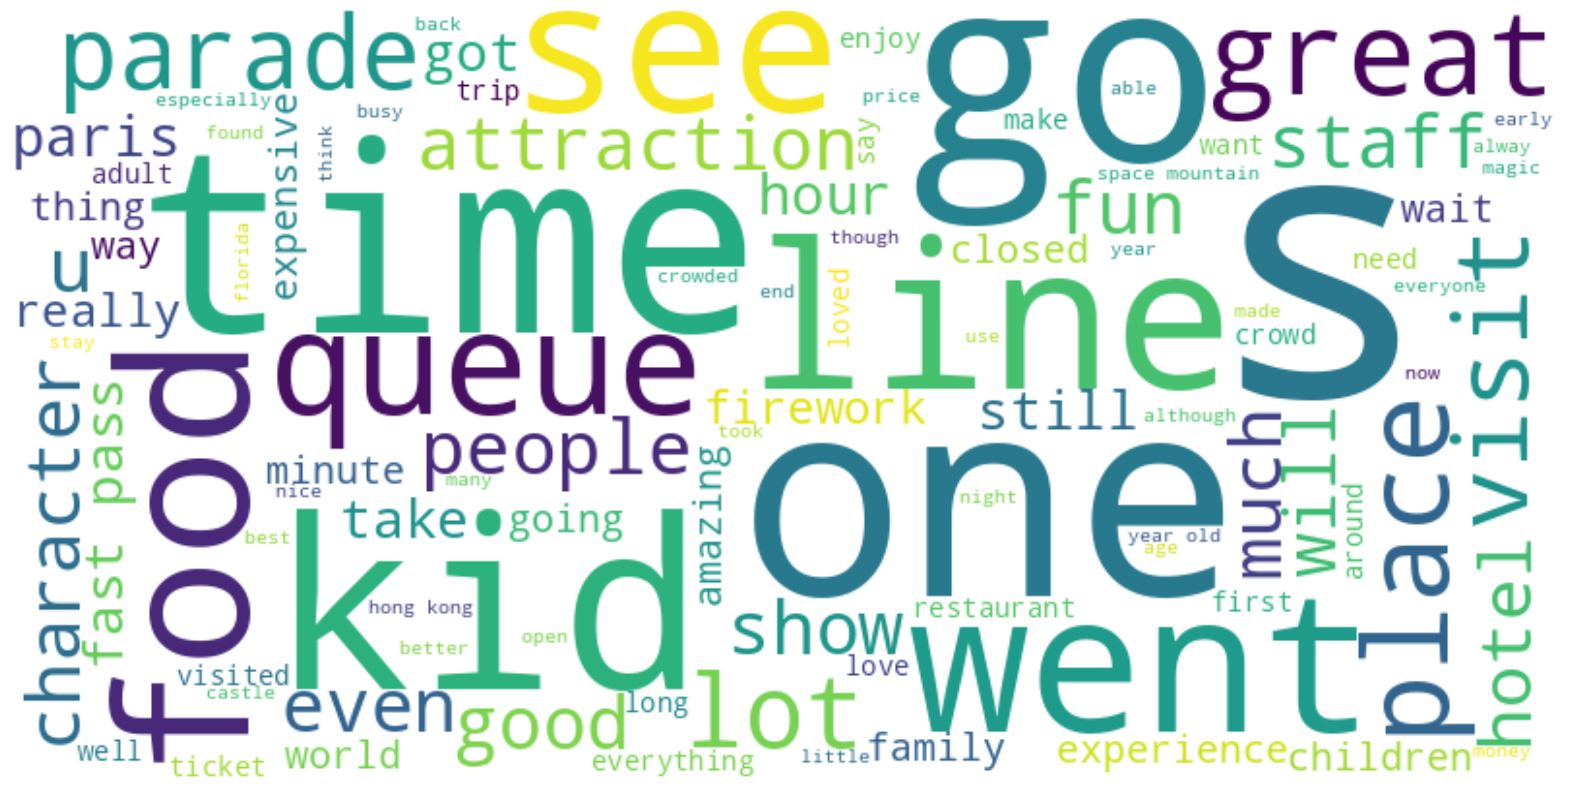

In [14]:
# todas as avaliações
wc = WordCloud(width=800, height=400, max_font_size=200, max_words=100, background_color="white").generate(review_text)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

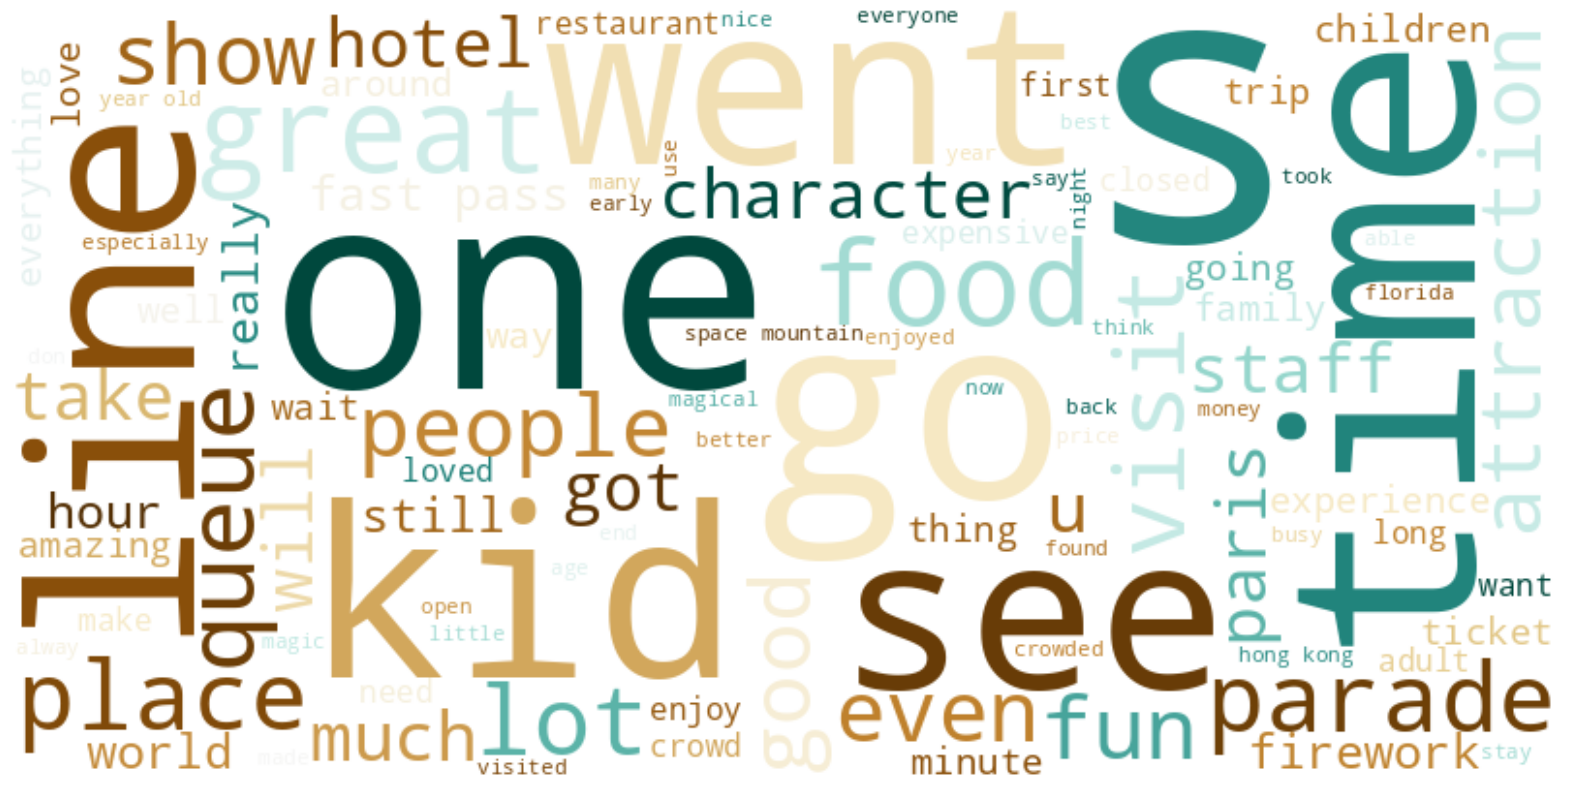

In [15]:
# avaliações positivas
positif = resultado.loc[resultado['Sentiment'] == "Positive"]
review_text = " ".join(i for i in positif['Reviews_Text'])
wc = WordCloud(width=800, height=400, max_font_size=200, max_words=100, background_color="white", colormap='BrBG', ).generate(review_text)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

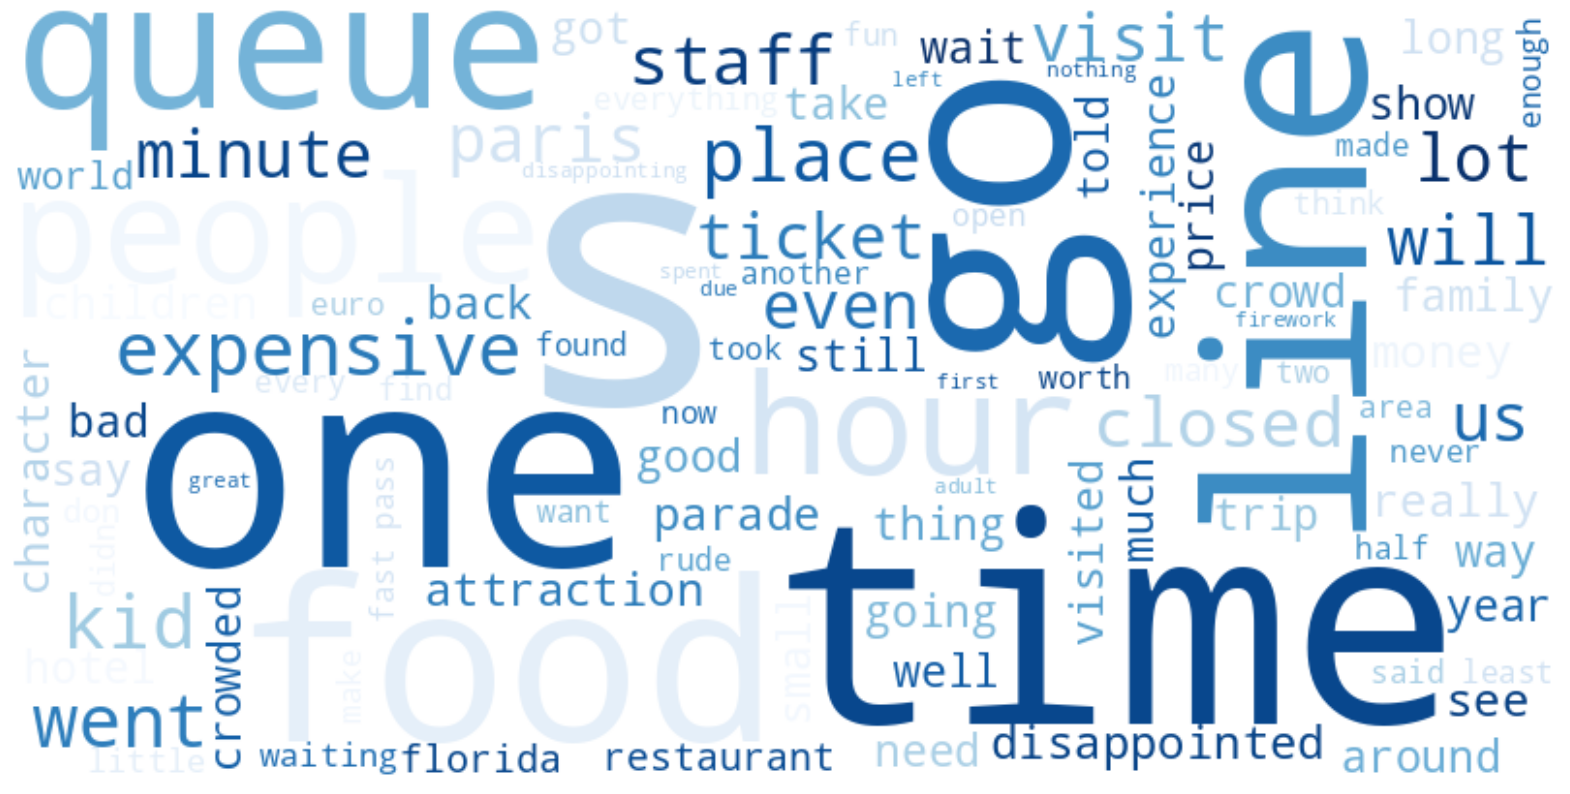

In [16]:
# avaliações negativas
negatif = resultado.loc[resultado['Sentiment'] == "Negative"]
review_text = " ".join(i for i in negatif['Reviews_Text'])
wc = WordCloud(width=800, height=400, max_font_size=200, max_words=100, background_color="white", colormap='Blues', ).generate(review_text)
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()